In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import time
import itertools
import random
import matplotlib.pyplot as plt

# First we will optimize over the space of the Sub-modular functions.


Here we will have $lp$ be learned tensor and $lq$ be the target tensor. 

We show the problem of $lp$ being sub modular and we want to minimize $\|lp - lq\|^2$. 


## Oracles

### Deterministic Oracle

We just go through all $\binom{n}{2} 2^{n-2}$ constraints and see which ones are violated. 

### Random Oralce

For each of the $\binom{n}{2}$ pairs, we sample $5n$ constraints randomly from the $2^{n-2}$ constraints. We return the violated ones. 

In [ ]:
# input is the tensor with the probability of a binary string given at that index. 
def deterministic_oracle(lp, pi, n, tol = 1e-10, exclude = [], sub = True):
  inequalities = []
  N = 2**(n)
  for i in range(n):
    if i in exclude:
        continue
    for j in range(i):
      if j in exclude:
        continue
      if pi[i] == "id" and pi[j] == "id":
        sgn = -1
      elif pi[i] == "switch" and pi[j] == "switch":
        sgn = -1
      else:
        sgn = 1
      if not sub:
        sgn += -1
      for k in range(N//4): #Think seeing every inequality 4 times. 
        p = format(k,"0"+str(n-2)+"b")
        p11 = list(format(k,"0"+str(n)+"b"))
        p22 = list(format(k,"0"+str(n)+"b"))
        p12 = list(format(k,"0"+str(n)+"b"))
        p21 = list(format(k,"0"+str(n)+"b"))
        idx = 0
        for l in range(n):
          if l != i and l != j:
            p11[l] = p[idx]
            p12[l] = p[idx]
            p21[l] = p[idx]
            p22[l] = p[idx]
            idx += 1
          elif l == i:
            p11[l] = "0"
            p12[l] = "0"
            p21[l] = "1"
            p22[l] = "1"
          elif l == j:
            p11[l] = "0"
            p12[l] = "1"
            p21[l] = "0"
            p22[l] = "1"
        p11 = "".join(p11)
        p12 = "".join(p12)
        p21 = "".join(p21)
        p22 = "".join(p22)
        
        a = int(p11,2)
        b = int(p22,2)
        c = int(p12,2)
        d = int(p21,2)

        # Checks if p11 p22 > p12 p21
        if lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn) < tol:
          key = tuple([a,b,c,d,sgn])
          if key not in inequalities:
            inequalities.append(tuple([a,b,c,d,sgn]))

  return inequalities

# input is the tensor with the probability of a binary string given at that index. 
def random_oracle(lp, pi, n, exclude = [], sub = True):
  inequalities = []
  N = 2**(n)
  for i in range(n):
    if i in exclude:
        continue
    for j in range(i):
      if j in exclude:
        continue
      if pi[i] == "id" and pi[j] == "id":
        sgn = -1
      elif pi[i] == "switch" and pi[j] == "switch":
        sgn = -1
      else:
        sgn = 1
      if not sub:
        sgn += -1
      for k in range(5*n):
        index = np.random.randint(N)
        p = format(index,"0"+str(n)+"b")
        p11 = list(p)
        p22 = list(p)
        p12 = list(p)
        p21 = list(p)
        idx = 0
        for l in range(n):
          if l != i and l != j:
            p11[l] = p[idx]
            p12[l] = p[idx]
            p21[l] = p[idx]
            p22[l] = p[idx]
            idx += 1
          elif l == i:
            p11[l] = "0"
            p12[l] = "0"
            p21[l] = "1"
            p22[l] = "1"
          elif l == j:
            p11[l] = "0"
            p12[l] = "1"
            p21[l] = "0"
            p22[l] = "1"
        p11 = "".join(p11)
        p12 = "".join(p12)
        p21 = "".join(p21)
        p22 = "".join(p22)
        
        a = int(p11,2)
        b = int(p22,2)
        c = int(p12,2)
        d = int(p21,2)

        if lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn) < 0:
          key = tuple([a,b,c,d,sgn])
          inequalities.append(tuple([a,b,c,d,sgn]))

  return inequalities

def solve(lq, pi, iters = 100, random = False, exclude = [], sub = True):
  N = lq.shape[0]
  n = int(np.log2(N))

  lp = torch.clone(lq)
  Z = dict()

  for iteration in range(iters):
    if random:
      inequalities = random_oracle(lp, pi, n, exclude = exclude, sub = sub)
    else:
      inequalities = deterministic_oracle(lp, pi, n, exclude = exclude, sub = sub)
    max_deficit = 0
    for key in inequalities:
      a,b,c,d,sgn = key

      deficit = lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn)
      if deficit < max_deficit:
        max_deficit = deficit 
      if key in Z:
        z = Z[key]
      else:
        z = 0
        Z[key] = 0
      theta = min(deficit/4,z)

      lp[a] += -sgn*theta
      lp[b] += -sgn*theta
      lp[c] += sgn*theta
      lp[d] += sgn*theta

      if abs(z - theta) < 1e-10:
        del Z[key]
      else:
        Z[key] -= theta

    for _ in range(5):
      deletes = []
      for key in Z:
        a,b,c,d,sgn = key

        deficit = lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn)
        if deficit < max_deficit:
          max_deficit = deficit 
        z = Z[key]

        theta = min(deficit/4,z)

        lp[a] += -sgn*theta
        lp[b] += -sgn*theta
        lp[c] += sgn*theta
        lp[d] += sgn*theta

        if abs(z - theta) < 1e-10:
          deletes.append(key)
        else:
          Z[key] -= theta
        
      for key in deletes:
        del Z[key]

    # if iteration % 20 == 0:
    #   print((lp-lq).square().sum().sqrt(), max_deficit, len(Z))

    if max_deficit > -1e-6*torch.norm(lq):
      return lp


  return lp

def calc_low_rank_approx(lq,r, iters = 1000, sub = True, random = False):
  N = lq.shape[0]
  n = int(np.log2(N))
  partitions = list(itertools.combinations(list(range(n)), r))
  best_exclude = []
  best_lp = lq
  best_error = float('inf')
  for ex in partitions:
    exclude = list(ex)
    lp = solve(lq, ['id' for _ in range(n)], iters, random = random, exclude = exclude, sub = sub)
    if (lp-lq).square().sum() < best_error:
      best_error = (lp-lq).square().sum() 
      best_lp = lp
      best_exclude = exclude
  return best_error, best_lp, best_exclude

def check_low_rank_approx(lq,r, sub = True):
  N = lq.shape[0]
  n = int(np.log2(N))
  partitions = list(itertools.combinations(list(range(n)), r))
  for ex in partitions:
    exclude = list(ex)
    ineqs = deterministic_oracle(lq, ['id' for _ in range(n)], n, exclude = exclude, sub = sub)
    if len(ineqs) == 0:
      return True
  return False

In [ ]:
volumes = torch.zeros(5,5)
T = 5000000

for i,n in enumerate(range(5,8)):
  for r in range(0,5):
    if r > n-1:
      continue
    for t in tqdm(range(T)):
      lq = torch.randn(2**n)
      if check_low_rank_approx(lq,r):
        volumes[i,r] += 1/T
    print(volumes[i,:])
    


100%|██████████| 5000000/5000000 [7:33:10<00:00, 183.89it/s]


tensor([0., 0., 0., 0., 0.])


  2%|▏         | 101462/5000000 [27:00<21:39:38, 62.82it/s]

In [ ]:
times = torch.zeros(8)
diff = torch.zeros(8)
n = 8

lq = (torch.rand(2**n)+10).log()

for r in range(7):
  t0 = time.time()
  be, blp, bex = calc_low_rank_approx(lq,r, iters = 1000, random = False)
  t1 = time.time()

  times[r] = t1-t0
  diff[r] = torch.norm(lq-blp)/torch.norm(lq)

  print(times[r], diff[r], bex)

  

# Greedy Maximization

In [ ]:
import itertools
import random
from tqdm import tqdm
import torch
import numpy as np

def calc_union(S,Omega,n):
  x = list(format(S,"0"+str(n)+"b"))
  y = list(format(Omega,"0"+str(n)+"b"))
  for i in range(n):
    if x[i] == "1":
      y[i] = "1"
  return int("".join(y),2)

def rho(f,S,Omega):
  n = int(np.log2(f.shape[0]))
  x = calc_union(S,Omega,n)
  val = f[x] - f[S]
  return val

def are_disjoint(S,L,n):
  x = list(format(S,"0"+str(n)+"b"))
  y = list(format(L,"0"+str(n)+"b"))
  for i in range(n):
    if x[i] == "1" and y[i] == "1":
      return False
  return True

def calc_gamma(f, verbose = True):
  n = int(np.log2(f.shape[0]))
  gamma = 1
  for S in tqdm(range(2**n), disable = not verbose):
    for L in range(2**n):
      if are_disjoint(S,L,n):
        denom = rho(f, L, S)
        x = list(format(S,"0"+str(n)+"b"))
        y = list(format(L,"0"+str(n)+"b"))
        num = 0
        for i in range(n):
          if x[i] == "1":
            num += rho(f, L, L+(2**(n-1-i)))
        if num/denom < gamma:
          gamma = num/denom
  return gamma

def calc_alpha(f, verbose = True):
  n = int(np.log2(f.shape[0]))
  alpha = 1
  for S in tqdm(range(2**n), disable = not verbose):
    for Omega in range(2**n):
      x = list(format(S,"0"+str(n)+"b"))
      y = list(format(Omega,"0"+str(n)+"b"))
      for i in range(n):
        if x[i] == "1" and y[i] == "0":
          denom = rho(f, S-(2**(n-1-i)), 2**(n-1-i))
          num = rho(f, calc_union(S-(2**(n-1-i)), Omega, n), 2**(n-1-i))
          if num/denom < alpha:
            alpha = num/denom
  return 1-alpha

# S be a list
# x is number corresponding to the particular restriction. 
def calc_restricted(f,S,x_string):
  n = int(np.log2(f.shape[0]))
  k = len(S)
  g = torch.zeros(2**(n-k))
  # x_string = list(format(x,"0"+str(n)+"b"))
  for i in range(2**(n-k)):
    i_string = list(format(i,"0"+str(n)+"b"))
    y = list(format(0,"0"+str(n)+"b"))
    idx = 0
    idx_x = 0
    for j in range(n):
      if j in S:
        y[j] = x_string[idx_x]
        idx_x += 1
      else:
        y[j] = i_string[idx]
        idx += 1
    g[i] = f[int("".join(y),2)]
  return g

def calc_alpha_restricted(f,k):
  n = int(np.log2(f.shape[0]))
  idxs = list(itertools.combinations(list(range(n)), k))
  min_alpha = 0
  for index_set in tqdm(idxs):
    max_alpha = 0
    for vals in range(2**k):
      pattern = list(format(vals,"0"+str(k)+"b"))
      # S = list(format(0,"0"+str(n)+"b"))
      # for i,j in enumerate(index_set):
      #   S[j] = pattern[i] 
      # x = int("".join(S),2)
      g = calc_restricted(f, index_set, pattern)
      # print(index_set, x, g, g.shape)
      alpha = calc_alpha(g, False)
      if alpha > max_alpha:
        max_alpha = alpha
    if min_alpha < max_alpha:
      min_alpha = max_alpha
  return min_alpha

def calc_gamma_restricted(f,k):
  n = int(np.log2(f.shape[0]))
  idxs = list(itertools.combinations(list(range(n)), k))
  max_gamma = 1
  for index_set in tqdm(idxs):
    min_gamma = 1
    for vals in range(2**k):
      pattern = list(format(vals,"0"+str(k)+"b"))
      # S = list(format(0,"0"+str(n)+"b"))
      # for i,j in enumerate(index_set):
      #   S[j] = pattern[i] 
      # x = int("".join(S),2)
      g = calc_restricted(f, index_set, pattern)
      # print(g, g.shape)
      gamma = calc_gamma(g, False)
      if gamma < min_gamma:
        min_gamma = gamma
    if min_gamma < max_gamma:
      max_gamma = min_gamma
    
  return max_gamma
  
def discrete_gradient(f,x,n,exclude = []):
  S = list(format(x,"0"+str(n)+"b"))
  max_val = -1*float("inf")
  max_index = -1
  for i in range(n):
    if i not in exclude:
      if S[i] == "0":
        S_new = S.copy()
        S_new[i] = "1"
        x_new = int("".join(S_new),2)
        if f(x_new) > max_val:
          max_val = f(x_new)
          max_index = x_new
  
  return max_val, max_index

def check_monotone(f):
  n = int(np.log2(f.shape[0]))
  for x in range(2**n):
    S = list(format(x,"0"+str(n)+"b"))
    for i in range(n):
      if S[i] == "0":
        T = list(format(0,"0"+str(n)+"b"))
        T[i] = "1"
        y = int("".join(T),2)
        if rho(f,x,y) < 0:
          return False
  return True

def greedy_size_constraint(f, x, M, n, exclude = []):
  for i in range(M):
    _, x = discrete_gradient(f,x,n,exclude)
    # print(x,f[x])
  
  return x, f(x)

def make_order(n,k = None):
  if k == None:
    k = n

  order = torch.zeros(2**n, dtype = torch.long)

  idx = 0
  order[idx] = 0
  idx += 1
  for i in range(1,k+1):
    idxs = list(itertools.combinations(list(range(n)), i))
    random.shuffle(idxs)
    for index_set in idxs:
      S = list(format(0,"0"+str(n)+"b"))
      for j in index_set:
        S[j] = "1"
      x = int("".join(S),2)
      order[idx] = x
      idx += 1

  return order[:idx]

def make_monotone(f):
  n = int(np.log2(f.shape[0]))
  g = torch.zeros_like(f)
  p = torch.sort(f).values
  order = make_order(n)

  for i in range(2**n):
    g[order[i]] = p[i]

  g -= g[0] - 1
  
  return g 

def more_compute_greedy_constrained(f,M,k,n):
  max_val = -1*float("inf")
  max_index = -1

  idxs = list(itertools.combinations(list(range(n)), k))
  for index_set in idxs:
    pattern = list(format(2**k-1,"0"+str(k)+"b"))
    S = list(format(0,"0"+str(n)+"b"))
    count = 0
    # print(vals, pattern)
    for i,j in enumerate(index_set):
      S[j] = pattern[i] 
      if pattern[i] == "1":
        count += 1
    x = int("".join(S),2)
    # print(x)

    max_index_new, max_val_new = greedy_size_constraint(f,x,M-k,n,index_set)
    if max_val_new > max_val:
      max_val = max_val_new
      max_index = max_index_new

  return max_val, max_index

def modified_greedy_constrained(f,M,k,n):
  max_val = -1*float("inf")
  max_index = -1

  idxs = list(itertools.combinations(list(range(n)), k))
  for index_set in idxs:
    # print(index_set)
    for vals in range(2**k):
      pattern = list(format(vals,"0"+str(k)+"b"))
      S = list(format(0,"0"+str(n)+"b"))
      count = 0
      # print(vals, pattern)
      for i,j in enumerate(index_set):
        S[j] = pattern[i] 
        if pattern[i] == "1":
          count += 1
      x = int("".join(S),2)
      # print(x)

      max_index_new, max_val_new = greedy_size_constraint(f,x,M-count,n,index_set)
      if max_val_new > max_val:
        max_val = max_val_new
        max_index = max_index_new

  return max_val, max_index

def column_subset_problem(m,n, M):
  A = torch.rand(m,n)
  f = torch.zeros(2**n)
  order = make_order(n,M)

  for i in order:
    S = format(i,"0"+str(n)+"b")
    indexes = torch.zeros(n, dtype = torch.long)
    idx = 0
    for j in range(n):
      if S[j] == "1":
        indexes[idx] = j
        idx += 1
    indexes = indexes[:idx]
    A_S = A[:,indexes]
    P = A_S.mm(torch.linalg.pinv(A_S))
    B = P.mm(A)
    f[i] = A.square().sum() - B.square().sum()

  f *= -1
  f -= f[0].item()

  return f

def column_subset_problem_f(i):
  S = format(i,"0"+str(n)+"b")
  indexes = torch.zeros(n, dtype = torch.long)
  idx = 0
  for j in range(n):
    if S[j] == "1":
      indexes[idx] = j
      idx += 1
  indexes = indexes[:idx]

  A_S = A[:,indexes]
  P = A_S.mm(torch.linalg.pinv(A_S))
  B = P.mm(A)
  return B.square().sum()

def bayesian_A_optimality(X, beta, sigma, M):
  d,n = X.shape

  Lambda = torch.eye(d)*beta*beta
  f = torch.zeros(2**n)
  order = make_order(n,M)

  for i in order:
    S = format(i,"0"+str(n)+"b")
    indexes = torch.zeros(n, dtype = torch.long)
    idx = 0
    for j in range(n):
      if S[j] == "1":
        indexes[idx] = j
        idx += 1
    indexes = indexes[:idx]
    X_S = X[:,indexes]
    
    f[i] = torch.trace(torch.linalg.inv(Lambda)) - torch.trace(torch.linalg.inv(Lambda + X_S.mm(X_S.t())/(sigma*sigma)))

  return f

def bayesian_A_optimality_f(i):
  d,n = X.shape

  Lambda = torch.eye(d)*beta
  theta = torch.randn(d)/beta

  S = format(i,"0"+str(n)+"b")
  indexes = torch.zeros(n, dtype = torch.long)
  idx = 0
  for j in range(n):
    if S[j] == "1":
      indexes[idx] = j
      idx += 1
  indexes = indexes[:idx]
  X_S = X[:,indexes]
  
  return d/(beta*beta) - torch.trace(torch.linalg.inv(Lambda + X_S.mm(X_S.t())/(sigma*sigma)))

def determinantal_f(i):
  n,n = Sigma.shape

  S = format(i,"0"+str(n)+"b")
  indexes = torch.zeros(n, dtype = torch.long)
  idx = 0
  for j in range(n):
    if S[j] == "1":
      indexes[idx] = j
      idx += 1
  indexes = indexes[:idx]
  Sigma_S = Sigma[:,indexes]/sigma
  Sigma_SS = Sigma_S[indexes,:]/sigma
    
  return torch.linalg.det(torch.eye(len(indexes)) + Sigma_SS)

def determinantal(Sigma, sigma, M):
  n,n = Sigma.shape

  f = torch.zeros(2**n)
  order = make_order(n,M)

  for i in order:
    S = format(i,"0"+str(n)+"b")
    indexes = torch.zeros(n, dtype = torch.long)
    idx = 0
    for j in range(n):
      if S[j] == "1":
        indexes[idx] = j
        idx += 1
    indexes = indexes[:idx]
    Sigma_S = Sigma[:,indexes]/sigma
    Sigma_SS = Sigma_S[indexes,:]/sigma
    
    f[i] = torch.linalg.det(torch.eye(len(indexes)) + Sigma_SS)
  return f
  
def bound(alpha,gamma):
  return (1-(-1*alpha*gamma).exp())/alpha

def bound_deter(gamma):
  return (1-(-1*gamma).exp())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compute $\alpha_r$ and $\gamma_r$

Should change the function for computing

In [ ]:
alphas = torch.zeros(8,5,8)

for n in range(8,10):
  for iter in range(5):
    X = torch.rand(n,n)
    Sigma = X.mm(X.t())
    sigma = 1
    f = determinantal(X.mm(X.t()), sigma)

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,6):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alphas-determinantal-"+str(n)+".pt")


In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    X = torch.randn(60,n)
    beta = 0.1
    sigma = 0.1
    f = bayesian_A_optimality(X,beta,sigma,n)

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-bayesian-"+str(n)+".pt")

In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    X = torch.rand(n,n)
    Sigma = X.mm(X.t())
    sigma = 1
    f = determinantal(X.mm(X.t()), sigma,n)

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-determinantal-"+str(n)+".pt")

In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = make_monotone(torch.rand(2**n))

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-random-"+str(n)+".pt")

In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = column_subset_problem(20,n,n)

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-column-"+str(n)+".pt")

In [ ]:
alphas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    X = torch.randn(60,n)
    beta = 0.1
    sigma = 0.1
    f = bayesian_A_optimality(X,beta,sigma,n)

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,5):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alpha-ks-bayesian-"+str(n)+".pt")

In [ ]:
alphas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = column_subset_problem(20,n,n)

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,5):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alpha-ks-column-"+str(n)+".pt")

In [ ]:
alphas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = make_monotone(torch.randn(2**n))

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,5):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alpha-ks-random-"+str(n)+".pt")

Load the results

In [ ]:
gammas_col = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-column-8.pt")
gammas_rand = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-random-8.pt")
gammas_det = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-determinantal-8.pt")
gammas_bayesian = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-bayesian-8.pt")

alphas_col = torch.load("drive/MyDrive/JIM/alpha-ks-minmax-column-8.pt")
alphas_rand = torch.load("drive/MyDrive/JIM/alpha-ks-minmax-random-8.pt")
alphas_det = torch.zeros_like(alphas_col) #torch.load("drive/MyDrive/JIM/alpha-ks-minmax-determinantal-8.pt")
alphas_bayesian = torch.load("drive/MyDrive/JIM/alpha-ks-minmax-bayesian-8.pt")

Compute the bounds 

In [ ]:
bound_col = bound(alphas_col,gammas_col)
bound_det = bound_deter(gammas_det)
bound_rand = bound(alphas_rand,gammas_rand)
bound_bay = bound(alphas_bayesian,gammas_bayesian)

Plot the results

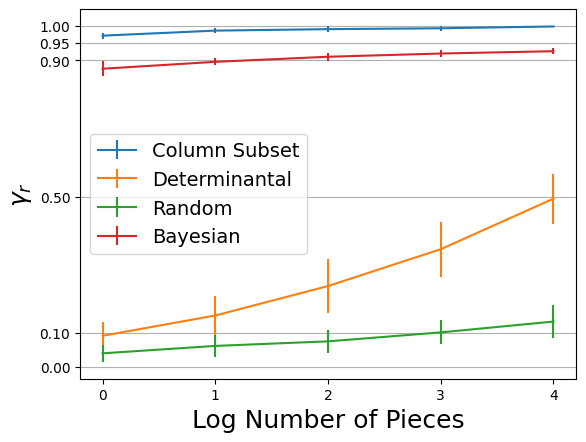

In [ ]:
plt.errorbar([0,1,2,3,4], gammas_col[0,:,:].mean(dim=0), yerr = gammas_col[0,:,:].std(dim=0), label = "Column Subset")
plt.errorbar([0,1,2,3,4], gammas_det[0,:,:].mean(dim=0), yerr = gammas_det[0,:,:].std(dim=0),label = "Determinantal")
plt.errorbar([0,1,2,3,4], gammas_rand[0,:,:].mean(dim=0), yerr = gammas_rand[0,:,:].std(dim=0),label = "Random")
plt.errorbar([0,1,2,3,4], gammas_bayesian[0,:,:].mean(dim=0), yerr = gammas_bayesian[0,:,:].std(dim=0),label = "Bayesian")

plt.legend(fontsize=14)
plt.xlabel("")
plt.xticks([0,1,2,3,4])
plt.yticks([0,0.1,0.5,0.9,0.95,1])
plt.grid(axis='y')
plt.xlabel("Log Number of Pieces", fontsize=18)
plt.ylabel(r"$\gamma_r$", fontsize=18)
plt.savefig("ratios.pdf", dpi = 300, facecolor = "white", bbox_inches="tight")

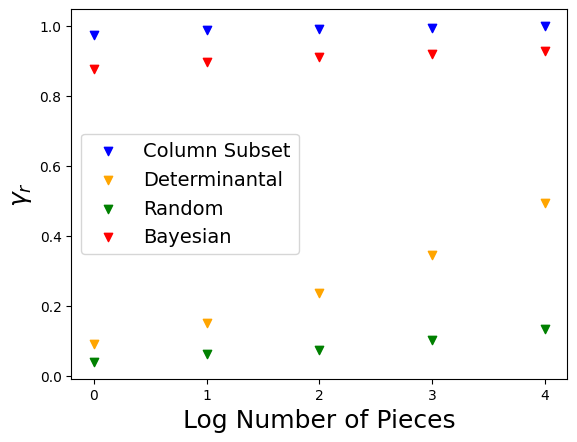

In [ ]:
plt.scatter([0,1,2,3,4], gammas_col[0,:,:].mean(dim=0), c = "b", label = "Column Subset", marker = "v")
plt.scatter([0,1,2,3,4], gammas_det[0,:,:].mean(dim=0), color = "orange", label = "Determinantal", marker = "v")
plt.scatter([0,1,2,3,4], gammas_rand[0,:,:].mean(dim=0), c = "g", label = "Random", marker = "v")
plt.scatter([0,1,2,3,4], gammas_bayesian[0,:,:].mean(dim=0), c = "r", label = "Bayesian", marker = "v")

plt.legend(fontsize=14)
plt.xlabel("")
plt.xticks([0,1,2,3,4])
# plt.grid(axis='y')
plt.xlabel("Log Number of Pieces", fontsize=18)
plt.ylabel(r"$\gamma_r$", fontsize=18)
plt.savefig("gamma-k.pdf", dpi = 300, facecolor = "white", bbox_inches="tight")

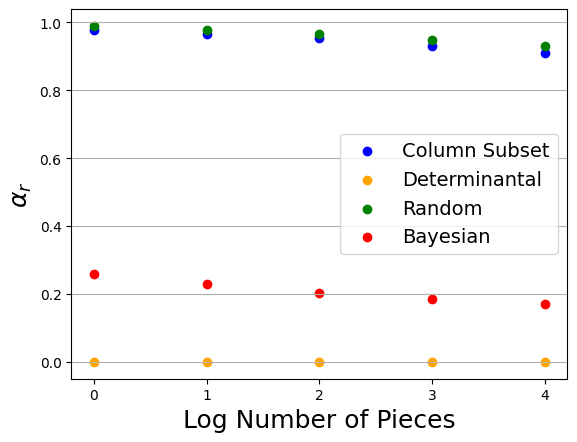

In [ ]:
plt.scatter([0,1,2,3,4], alphas_col[0,:,:].mean(dim=0), c = "b", label = "Column Subset")
plt.scatter([0,1,2,3,4], alphas_det[0,:,:].mean(dim=0), color = "orange", label = "Determinantal")
plt.scatter([0,1,2,3,4], alphas_rand[0,:,:].mean(dim=0), c = "g", label = "Random")
plt.scatter([0,1,2,3,4], alphas_bayesian[0,:,:].mean(dim=0), c = "r", label = "Bayesian")

plt.legend(fontsize=14)
plt.xlabel("")
plt.xticks([0,1,2,3,4])
# plt.grid(axis='y')
plt.xlabel("Log Number of Pieces", fontsize=18)
plt.ylabel(r"$\alpha_r$", fontsize=18)
plt.savefig("alpha-k.pdf", dpi = 300, facecolor = "white", bbox_inches="tight")

## Compute Low Rank Approximation

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.rand(n,2*n)
    Sigma = X.mm(X.t())
    sigma = 0.1
    f = determinantal(X.mm(X.t()), sigma, n)
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/determinantal-low-rank-approximation-n-7.pt")

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = make_monotone(torch.rand(2**n))
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/random-low-rank-approximation-n-7.pt")

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = column_subset_problem(60,n,n)
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/column-low-rank-approximation-n-7.pt")

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.randn(60,n)
    beta = 1
    sigma = 0.01
    f = bayesian_A_optimality(X,beta,sigma,n)
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/bayesian-low-rank-approximation-n-7.pt")

Plot the results

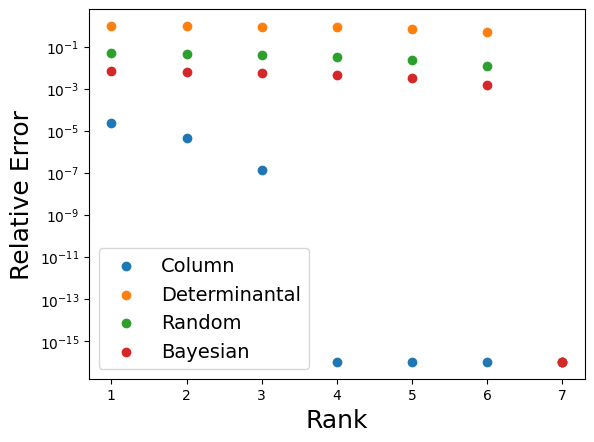

In [ ]:
error_d, time_d = torch.load("drive/MyDrive/JIM/determinantal-low-rank-approximation-n-7.pt")
error_r, time_r = torch.load("drive/MyDrive/JIM/random-low-rank-approximation-n-7.pt")
error_c, time_c = torch.load("drive/MyDrive/JIM/column-low-rank-approximation-n-7.pt")
error_b, time_b = torch.load("drive/MyDrive/JIM/bayesian-low-rank-approximation-n-7.pt")
rs = [1,2,3,4,5,6,7]


plt.scatter(rs, error_c.mean(dim=1)+1e-16, label = "Column")
plt.scatter(rs, error_d.mean(dim=1)+1e-16, label = "Determinantal")
plt.scatter(rs, error_r.mean(dim=1)+1e-16, label = "Random")
plt.scatter(rs, error_b.mean(dim=1)+1e-16, label = "Bayesian")
plt.yscale("log")
plt.xlabel("Rank", fontsize=18)
plt.ylabel("Relative Error", fontsize=18)
plt.legend(fontsize=14)
plt.savefig("error.pdf", dpi = 300, bbox_inches = "tight", facecolor="white")

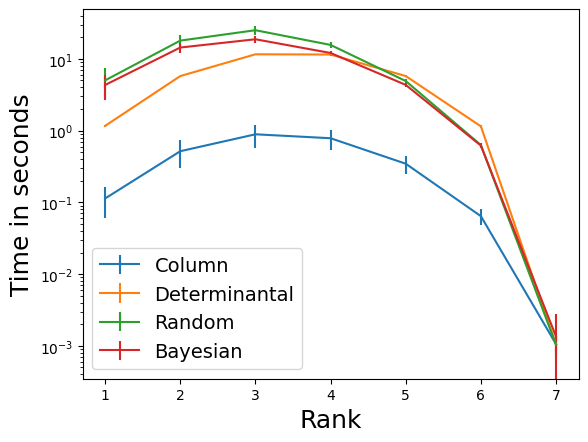

In [ ]:
plt.errorbar(rs, time_c.mean(dim=1)+1e-16, yerr = time_c.std(dim=1), label = "Column")
plt.errorbar(rs, time_d.mean(dim=1)+1e-16, yerr = time_d.std(dim=1), label = "Determinantal")
plt.errorbar(rs, time_r.mean(dim=1)+1e-16, yerr = time_r.std(dim=1), label = "Random")
plt.errorbar(rs, time_b.mean(dim=1)+1e-16, yerr = time_b.std(dim=1), label = "Bayesian")
plt.yscale("log")
plt.xlabel("Rank", fontsize=18)
plt.ylabel("Time in seconds", fontsize=18)
plt.legend(fontsize=14)
plt.savefig("time.pdf", dpi = 300, bbox_inches = "tight", facecolor="white")

## Small $n$ experiment

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.rand(n,2*n)
    Sigma = X.mm(X.t())
    sigma = 0.1
    f = determinantal(X.mm(X.t()), sigma, M)
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/determinantal/larger-results-"+str(n)+".pt")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.randn(60,n)
    beta = 1
    sigma = 0.01
    f = bayesian_A_optimality(X,beta,sigma,M)
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/bayesian/larger-results-"+str(n)+".pt")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = make_monotone(torch.randn(2**n))
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/random/larger-results-"+str(n)+".pt")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = column_subset_problem(40,n,M)
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/column/larger-results-"+str(n)+".pt")

Plot the results

In [ ]:
datanames = ["determinantal", "bayesian", "random", "column"]

T = 50

greedy_opt = torch.zeros(4)
greedy_prop = torch.zeros(4,T)

split_1_greedy_opt = torch.zeros(4)
split_1_greedy_prop = torch.zeros(4,T)

split_2_greedy_opt = torch.zeros(4)
split_2_greedy_prop = torch.zeros(4,T)

split_3_greedy_opt = torch.zeros(4)
split_3_greedy_prop = torch.zeros(4,T)

idx = 1


for i,name in enumerate(datanames):
  if name == "determinantal":
    optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy = torch.load("drive/MyDrive/JIM/"+name+"/larger-results-20.pt")
  else:
    optimal, greedy, split_greedy = torch.load("drive/MyDrive/JIM/"+name+"/larger-results-20.pt")

  print(optimal[:,2])

  greedy_opt[i] = (optimal[idx,:] == greedy[idx,:]).sum()/T
  split_1_greedy_opt[i] = (optimal[idx,:] == split_greedy[idx,0,:]).sum()/T
  split_2_greedy_opt[i] = (optimal[idx,:] == split_greedy[idx,1,:]).sum()/T
  split_3_greedy_opt[i] = (optimal[idx,:] == split_greedy[idx,2,:]).sum()/T

  greedy_prop[i] = (greedy[idx,:]/optimal[idx,:])
  split_1_greedy_prop[i] = (split_greedy[idx,0,:]/optimal[idx,:])
  split_2_greedy_prop[i] = (split_greedy[idx,1,:]/optimal[idx,:])
  split_3_greedy_prop[i] = (split_greedy[idx,2,:]/optimal[idx,:])

tensor([6.4225e+24, 7.8347e+26, 0.0000e+00, 0.0000e+00])
tensor([10.2293, 10.3497])
tensor([6.2502, 6.4461])
tensor([199.4597, 233.2367])


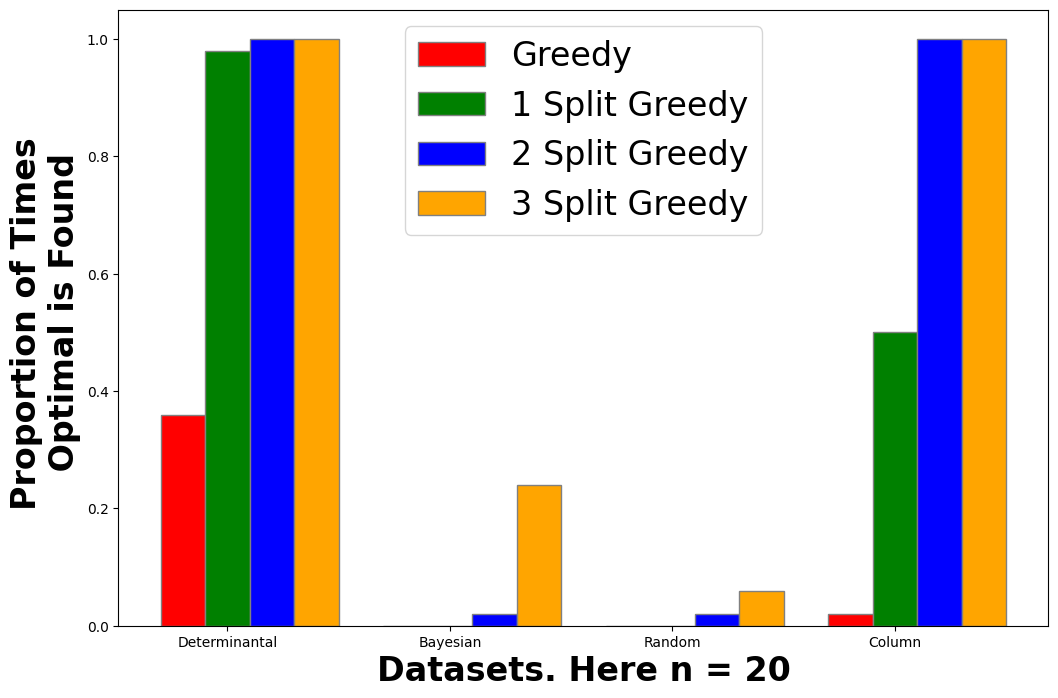

In [ ]:
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))


br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, greedy_opt, color ='r', width = barWidth,
        edgecolor ='grey', label ='Greedy')
plt.bar(br2, split_1_greedy_opt, color ='g', width = barWidth,
        edgecolor ='grey', label ='1 Split Greedy')
plt.bar(br3, split_2_greedy_opt, color ='b', width = barWidth,
        edgecolor ='grey', label ='2 Split Greedy')
plt.bar(br4, split_3_greedy_opt, color ='orange', width = barWidth,
        edgecolor ='grey', label ='3 Split Greedy')

plt.xlabel('Datasets. Here n = 20', fontweight ='bold', fontsize = 24)
plt.ylabel('Proportion of Times \n Optimal is Found', fontweight ='bold', fontsize = 24)
plt.xticks([r + barWidth for r in range(4)],
        ['Determinantal', 'Bayesian', 'Random', 'Column'])
 
plt.legend(fontsize=24)
plt.savefig("opt-bar.pdf", bbox_inches = "tight", facecolor="white", dpi = 300)

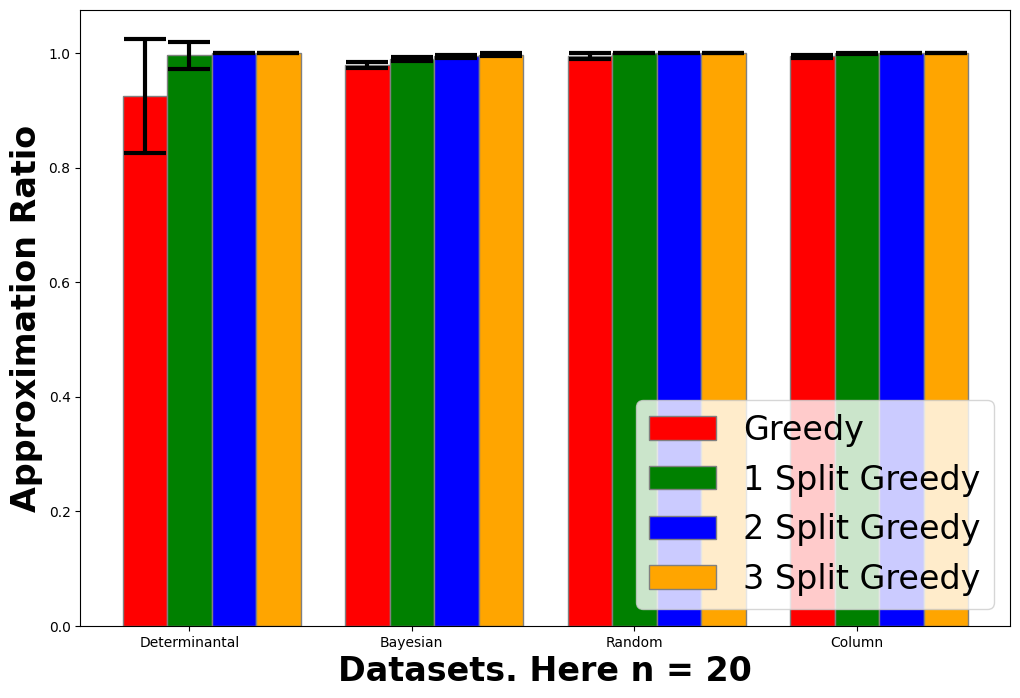

In [ ]:
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))


br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, greedy_prop.mean(dim=1), color ='r', width = barWidth, yerr = greedy_prop.std(dim=1), error_kw=dict(lw=3, capsize=15, capthick=3),
        edgecolor ='grey', label ='Greedy')
plt.bar(br2, split_1_greedy_prop.mean(dim=1), color ='g', width = barWidth,  yerr = split_1_greedy_prop.std(dim=1), error_kw=dict(lw=3, capsize=15, capthick=3),
        edgecolor ='grey', label ='1 Split Greedy')
plt.bar(br3, split_2_greedy_prop.mean(dim=1), color ='b', width = barWidth,  yerr = split_2_greedy_prop.std(dim=1), error_kw=dict(lw=3, capsize=15, capthick=3),
        edgecolor ='grey', label ='2 Split Greedy')
plt.bar(br4, split_3_greedy_prop.mean(dim=1), color ='orange', width = barWidth,  yerr = split_3_greedy_prop.std(dim=1), error_kw=dict(lw=3, capsize=15, capthick=3),
        edgecolor ='grey', label ='3 Split Greedy')

plt.xlabel('Datasets. Here n = 20', fontweight ='bold', fontsize = 24)
plt.ylabel('Approximation Ratio', fontweight ='bold', fontsize = 24)
plt.xticks([r + barWidth for r in range(4)],
        ['Determinantal', 'Bayesian', 'Random', 'Column'])

# plt.yscale("log")
# plt.ylim(0.8,1.03)

plt.legend(fontsize=24, loc = "lower right")
plt.savefig("opt-bar-ratio.pdf", bbox_inches = "tight", facecolor="white", dpi = 300)

## Large $n$ experiment

In [ ]:
Ns = [25,50,75,100,150,200,250,300,400,500]

greedy = torch.zeros(10,100)
greedy_1 = torch.zeros(10,100)
greedy_2 = torch.zeros(10,100)
greedy_m1 = torch.zeros(10,100)
greedy_m2 = torch.zeros(10,100)


for idx,n in enumerate(Ns):
  for trial in tqdm(range(100)):
    X = torch.rand(n,n)
    Sigma = X.mm(X.t())
    sigma = 1
    greedy[idx,trial] = greedy_size_constraint(determinantal_f,0,15,n)[1]
    greedy_1[idx,trial] = modified_greedy_constrained(determinantal_f,15,1,n)[0]
    # greedy_2[idx,trial] = modified_greedy_constrained(determinantal_f,15,2,n)[0]
    greedy_m1[idx,trial] = more_compute_greedy_constrained(determinantal_f,15,1,n)[0]
    # greedy_m2[idx,trial] = more_compute_greedy_constrained(determinantal_f,15,2,n)[0]

  print(greedy[idx,:].mean(),greedy_1[idx,:].mean(),greedy_m1[idx,:].mean(),(greedy_1[idx,:]/greedy_m1[idx,:]).mean())

  torch.save(greedy,"drive/MyDrive/JIM/greedy-determinantal"+str(n)+"-15.pt")
  torch.save(greedy_1,"drive/MyDrive/JIM/modified-greedy-1-determinantal-"+str(n)+"-15.pt")
  # torch.save(greedy_2,"drive/MyDrive/JIM/modified-greedy-2-determinantal-"+str(n)+"-15.pt")
  torch.save(greedy_m1,"drive/MyDrive/JIM/compute-greedy-1-determinantal-"+str(n)+"-15.pt")
  # torch.save(greedy_m2,"drive/MyDrive/JIM/compute-greedy-2-determinantal"+str(n)+"-15.pt")




100%|██████████| 100/100 [06:09<00:00,  3.70s/it]


tensor(2.8798e+08) tensor(3.0353e+08) tensor(3.0353e+08) tensor(1.)


100%|██████████| 100/100 [28:27<00:00, 17.08s/it]


tensor(2.8114e+12) tensor(3.1696e+12) tensor(3.1676e+12) tensor(1.0006)


100%|██████████| 100/100 [1:07:28<00:00, 40.49s/it]


tensor(7.4291e+14) tensor(8.4636e+14) tensor(8.4625e+14) tensor(1.0002)


100%|██████████| 100/100 [2:05:49<00:00, 75.49s/it]


tensor(3.9839e+16) tensor(4.6090e+16) tensor(4.6070e+16) tensor(1.0005)


100%|██████████| 100/100 [5:03:01<00:00, 181.81s/it]


tensor(1.2049e+19) tensor(1.3941e+19) tensor(1.3932e+19) tensor(1.0006)


100%|██████████| 100/100 [9:20:43<00:00, 336.44s/it]


tensor(7.2983e+20) tensor(8.1869e+20) tensor(8.1854e+20) tensor(1.0002)


 17%|█▋        | 17/100 [2:44:49<13:24:45, 581.75s/it]


KeyboardInterrupt: ignored

In [ ]:
(greedy_1[1,:]/greedy_m1[1,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0098, 1.0175,
        1.0326]),
indices=tensor([60, 73, 72, 71, 70, 69, 67, 66, 65, 64, 63, 62, 61, 74

In [ ]:
(greedy_1[2,:]/greedy_m1[2,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0007,
        1.0146]),
indices=tensor([62, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 76

In [ ]:
(greedy_1[3,:]/greedy_m1[3,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0013, 1.0022, 1.0097, 1.0129,
        1.0192]),
indices=tensor([61, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 74

In [ ]:
(greedy_1[4,:]/greedy_m1[4,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0030, 1.0062, 1.0164, 1.0174,
        1.0215]),
indices=tensor([60, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 73

In [ ]:
(greedy_1[5,:]/greedy_m1[5,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0006, 1.0015,
        1.0139]),
indices=tensor([61, 74, 73, 72, 71, 69, 68, 67, 66, 65, 64, 63, 62, 75

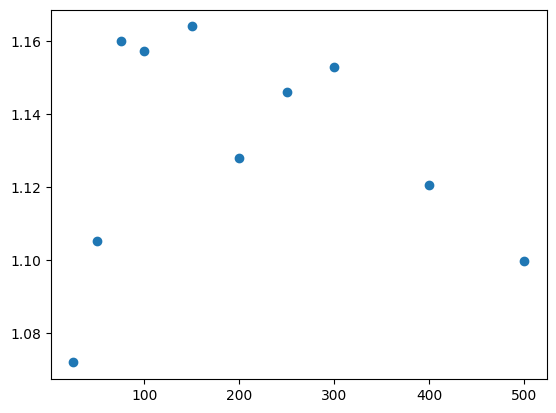

In [ ]:
import torch
Ns = [25,50,75,100,150,200,250,300,400,500]
ratios_d = torch.zeros(len(Ns))
rerrors_d = torch.zeros(len(Ns))
for i,n in enumerate(Ns):
  greedy = torch.load("drive/MyDrive/JIM/greedy-determinantal-"+str(n)+"-15.pt")
  greedy_1 = torch.load("drive/MyDrive/JIM/modified-greedy-1-determinantal-"+str(n)+"-15.pt")

  ratios_d[i] = (greedy_1[0,:]/greedy[0,:]).mean()
  rerrors_d[i] = (greedy_1[0,:]/greedy[0,:]).std()

plt.scatter(Ns, ratios_d)

In [ ]:
import torch
Ns = [25,50,75,100,150,200,250,300,400,500]
ratios_b = torch.zeros(len(Ns))
rerrors_b = torch.zeros(len(Ns))
for i,n in enumerate(Ns):
  greedy = torch.load("drive/MyDrive/JIM/greedy-bayesian-"+str(n)+"-15.pt")
  greedy_1 = torch.load("drive/MyDrive/JIM/modified-greedy-1-bayesian-"+str(n)+"-15.pt")

  ratios_b[i] = (greedy_1[i,:]/greedy[i,:]).mean()
  rerrors_b[i] = (greedy_1[i,:]/greedy[i,:]).std()

Text(0, 0.5, 'Ratio of Split Greedy to Greedy')

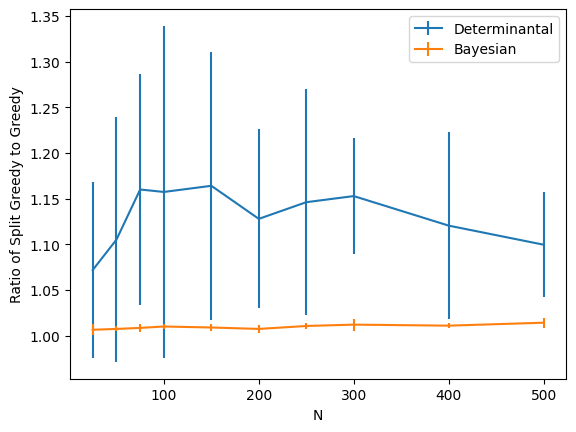

In [ ]:
plt.errorbar(Ns, ratios_d, yerr=rerrors_d, label = "Determinantal")
plt.errorbar(Ns, ratios_b, yerr=rerrors_b, label = "Bayesian")
plt.legend()
plt.xlabel("N")
plt.ylabel("Ratio of Split Greedy to Greedy")